In [41]:
import corv
import pyphot
from pyphot import unit
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pygaia.errors.astrometric import parallax_uncertainty
import pytorch_lightning as pl
import scipy.stats as ss

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

from sbi import model as nnmodel

In [42]:
npereader = nnmodel.load_model_from_path('test_weights/test')

In [43]:
model = corv.models.Spectrum('1d_da_nlte')
library = pyphot.get_library()

def forward(teff, distance, radius, bands = ['Gaia_G', 'Gaia_BP', 'Gaia_RP', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z']):
    pc_to_m = 3.0856775814671916e16
    rsun_to_m = 6.957e8
    bands = [library[band] for band in bands]
    wavl, interp = model.wavl, model.model_spec
    flux = interp((teff, 8)) * ((radius*rsun_to_m) / (distance * pc_to_m))**2
    band_flux = np.array([band.get_flux(wavl * unit['AA'], flux * unit['erg/s/cm**2/AA'], axis=1).value for band in bands])
    return band_flux

def sim_forward(teff, distance, radius, bands = ['Gaia_G', 'Gaia_BP', 'Gaia_RP', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z']):
    snr = np.random.uniform(300, 400)
    band_flux = forward(teff, distance, radius, bands)
    band_flux_noisy = np.random.normal(band_flux, band_flux/snr)

    gmag = -2.5 * np.log10(band_flux_noisy[0] / 2.4943e-09)
    plx_unc = parallax_uncertainty(gmag, release='dr3') * 1e-6
    plx = np.random.normal(loc = -0.000014 + (1 / distance), scale = plx_unc, size=(1))
    plx_data = np.concatenate([plx, np.array([plx_unc])])

    obs = np.concatenate([band_flux_noisy, band_flux_noisy/snr])
    return np.concatenate([plx_data, obs])

In [44]:
bands = ['Gaia_G', 'Gaia_BP', 'Gaia_RP', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z']
wavl = np.array([library[band].lpivot.to('AA').value for band in bands])

theta = np.array([10000, 100, 0.02])
data = sim_forward(*theta)

In [45]:
data

array([9.82351642e-03, 2.69238997e-04, 6.63626976e-17, 1.02973635e-16,
       3.61775525e-17, 1.59214200e-16, 1.26896244e-16, 6.93124606e-17,
       4.15064730e-17, 2.44350516e-17, 1.95087715e-19, 3.02713599e-19,
       1.06351856e-19, 4.68045084e-19, 3.73039361e-19, 2.03759191e-19,
       1.22017387e-19, 7.18321972e-20])

In [46]:
theta_samples = np.load('data/wdparams_theta.npy')
x_samples = np.load('data/wdparams_x.npy')

In [47]:
theta_samples[0]

array([1.13244641e+04, 3.97239183e+01, 1.51671172e-02])

In [48]:
# Convert to torch tensors
theta_samples = torch.tensor(theta_samples, dtype=torch.float32)
x_samples = torch.tensor(x_samples, dtype=torch.float32)

# Normalize the data
x_mean = x_samples.mean(dim=0)
x_std = x_samples.std(dim=0)
x_samples = (x_samples - x_mean) / x_std

theta_mean = theta_samples.mean(dim=0)
theta_std = theta_samples.std(dim=0)
theta_samples = (theta_samples - theta_mean) / theta_std

In [49]:
val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(x_samples))

dataset = TensorDataset(x_samples, theta_samples)

dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)

In [50]:
def build_mlp(input_dim, hidden_dim, output_dim, layers, activation=nn.GELU()):
    """Create an MLP from the configuration."""
    seq = [nn.Linear(input_dim, hidden_dim), activation]
    for _ in range(layers):
        seq += [nn.Linear(hidden_dim, hidden_dim), activation]
    seq += [nn.Linear(hidden_dim, output_dim)]
    return nn.Sequential(*seq)

In [51]:
def get_flow(d_in=2, d_hidden=32, d_context=16, n_layers=4):
    """ Instantiate a simple (Masked Autoregressive) normalizing flow.
    """
    base_dist = StandardNormal(shape=[d_in])

    transforms = []
    for _ in range(n_layers):
        transforms.append(ReversePermutation(features=d_in))
        transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, hidden_features=d_hidden, context_features=d_context))
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    return flow

# Instantiate flow
flow = get_flow()

# Make sure sampling and log-prob calculation makes sense
samples, log_prob = flow.sample_and_log_prob(num_samples=100, context=torch.randn(2, 16))
-log_prob[0]

tensor([ 5.4366,  5.2313,  5.4536,  6.8317,  6.0180,  8.9311,  5.6698,  6.7609,
         5.1518,  5.1533,  7.3043,  5.3303,  7.0886,  7.1450,  6.0798,  6.8213,
         5.6320,  5.2791,  5.2965,  5.1877,  7.0790,  6.3971,  4.9509,  6.6430,
        10.8676,  7.3603,  5.3696,  6.2843,  5.0492,  6.3360,  5.5287,  6.8108,
         7.9847,  6.1150,  8.9232,  4.9483,  6.7625,  8.9305,  5.2539,  5.7081,
         5.9097,  5.5009,  5.1032,  4.9144,  5.6412,  8.4150,  5.7639,  5.4018,
         5.1104,  5.0160,  4.9407,  9.3062,  6.1433,  5.3644,  7.2807,  5.0077,
         5.9897,  4.9999,  5.3341,  5.2447,  6.3025,  5.1980,  7.5167,  5.8695,
         4.9114,  5.5457,  5.4991,  5.0425,  5.5978,  5.8021,  5.2334,  4.9755,
        10.4875,  4.9503,  6.3054,  6.4941,  9.7080,  8.2223,  6.7210,  5.3071,
         5.2398,  5.9342,  5.8140,  4.9037,  7.6091,  5.0511,  6.6477,  5.6434,
         5.7090,  5.0603,  5.2815,  6.0573,  7.9190,  5.4508,  5.0139,  4.9963,
         5.3792,  7.2102,  6.1534,  6.23

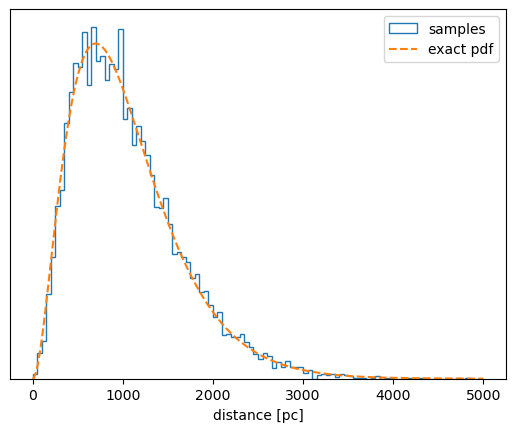

In [52]:
from torch.distributions import Chi2, transforms, transformed_distribution

L = 350
prior = transformed_distribution.TransformedDistribution(
        Chi2(6), transforms.AffineTransform(loc=0, scale=0.5 * L)
    )
r = prior.sample((10_000,))


x = np.linspace(0, 5000, 500)
plt.hist(r, 100, range=(0, 5000), density=True, histtype="step", label="samples")
plt.plot(x, 0.5 * x**2 * np.exp(-x / L) / L**3, "--", label="exact pdf")
plt.xlabel("distance [pc]")
plt.yticks([])
plt.legend();

In [53]:
def prior(theta, plx, e_plx, device, L = 350):
    # distance prior
    real_theta = theta * theta_std.to(device=device) + theta_mean.to(device=device)
    plx = plx * x_std[0].to(device=device) + x_mean[0].to(device=device)
    e_plx = e_plx * x_std[1].to(device=device) + x_mean[1].to(device=device)
    likelihood = torch.distributions.Normal(1/real_theta[:,1], e_plx).log_prob(plx)
    distance_prior = transformed_distribution.TransformedDistribution(
        Chi2(torch.tensor([6]).to(device=device)), 
        transforms.AffineTransform(loc=torch.tensor([0]).to(device=device), scale=torch.tensor([0.5 * L]).to(device=device))
    ).log_prob(real_theta[:,1])
    #uniform prior
    log_prior = torch.zeros(real_theta.shape[0], device=device)
    bounds = torch.tensor([[1000, 120000], [0, 2000], [0.001, 0.05]], device=device)
    for i in range(3):
        min_bound, max_bound = bounds[i]
        # Check if parameter i is within bounds for all examples
        within_bounds = (real_theta[:, i] >= min_bound) & (real_theta[:, i] <= max_bound)
        log_prior[~within_bounds] = np.inf
    return likelihood + distance_prior + log_prior 

In [54]:
from torch.distributions import Chi2, transformed_distribution

class NeuralPosteriorEstimator(pl.LightningModule):
    """ Simple neural posterior estimator class using a normalizing flow as the posterior density estimator.
    """
    def __init__(self, featurizer, d_context=8):
        super().__init__()
        self.d_in = 3
        self.featurizer = featurizer
        self.flow = get_flow(d_in=self.d_in, d_hidden=32, d_context=d_context, n_layers=4)
        self.prior = prior

    def forward(self, x):
        return self.featurizer(x)
    
    def loss(self, x, theta):     
        plx, e_plx, distance = x[:,0], x[:,1],  theta[:,1]
        prior = self.prior(theta, plx, e_plx, self.device)
        context = self(x[:,2:])
        return - self.flow.log_prob(inputs=theta, context=context) - prior

    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)
    

In [55]:
npe = NeuralPosteriorEstimator(build_mlp(input_dim=x_samples.shape[1]-2, hidden_dim=16, output_dim=16, layers=2), d_context=16)
(npe.loss(x_samples[:64], theta_samples[:64]) / x_samples.shape[1]).sum()

tensor(33.5952, grad_fn=<SumBackward0>)

In [58]:
import corner

theta_test = np.array([7000, 80, 0.01])
x_test = sim_forward(*theta_test, bands)
x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std

context = npereader.featurizer(x_test_norm[2:]).unsqueeze(0)
samples_test = npereader.flow.sample(num_samples=10000, context=context) * theta_std + theta_mean

True parameters:
temperature = 7000.0 K 
distance = 80.0 pc 
radius = 1.0975 r_earth


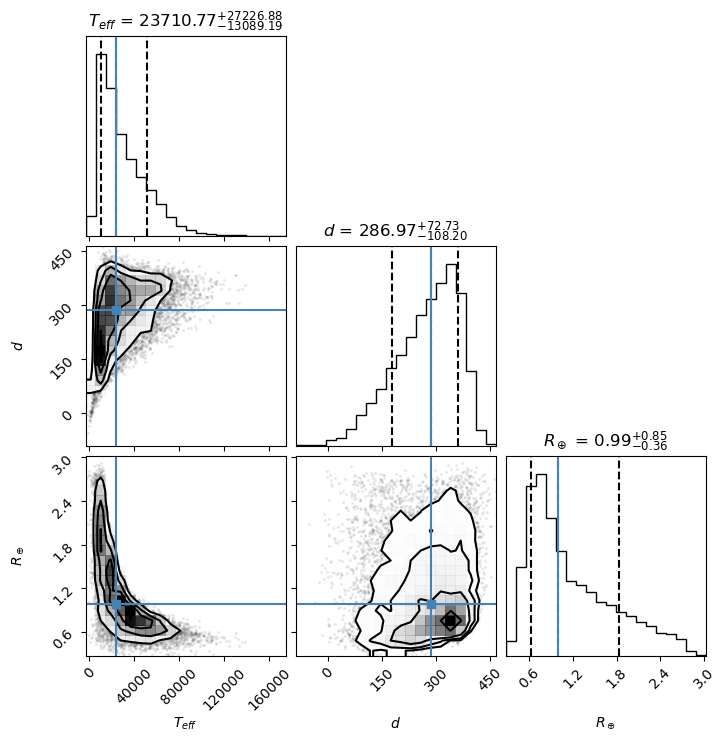

In [59]:
labels = [r"$T_{eff}$", r"$d$", r"$R_\oplus$"]
best_est = np.zeros((len(labels)))
unc = []

temp_chain = samples_test[0].detach().numpy()
temp_chain[:, 2] *= 109.075

for i in range(len(labels)):
    mcmc = np.percentile(temp_chain[:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

corner.corner(temp_chain, labels=labels, truths=best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.2f', title_kwargs={"fontsize": 12});
print(f"True parameters:\ntemperature = {theta_test[0]} K \ndistance = {theta_test[1]} pc \nradius = {theta_test[2]*109.75} r_earth")
plt.show()

## Test With Real Data

In [60]:
import pyvo

In [61]:
def get_ngf21():
    tap_service = pyvo.dal.TAPService("http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap/")
    QUERY = f"""select top 1000 *
            from \"J/MNRAS/508/3877/maincat\" as ngf
            join \"J/A+A/674/A33/gspc-wd\" as gspc 
            on ngf.GaiaEDR3 = gspc.GaiaDR3
            where ngf.e_TeffH is not NULL and ngf.e_loggH is not NULL and ngf.e_TeffHe is not NULL and ngf.e_loggHe is not NULL
            and RAND() < 0.01"""
    return tap_service.search(QUERY).to_table().to_pandas()

ngf21 = get_ngf21()

In [73]:
import scipy.stats as stats

ngf21['parallax_over_error'] = ngf21.Plx / ngf21.e_Plx
mu, sig = stats.norm.fit(ngf21['e_Plx'])

In [74]:
print("Location:", mu)
print("Scale:", sig)

Location: 0.19844757174392935
Scale: 0.09698311509385987


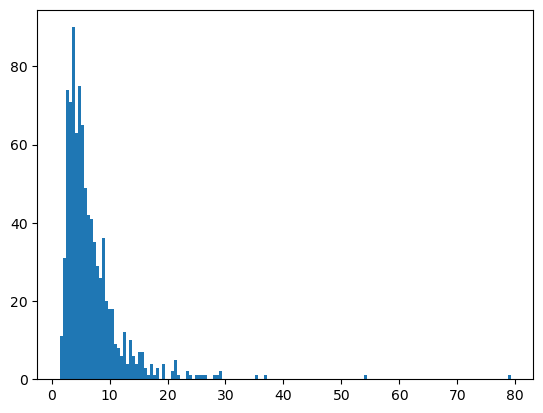

In [77]:
plt.hist(ngf21['Plx'], bins=150);

In [89]:
counts, bins = np.histogram(ngf21['Plx'], bins = 100)
naive_probs = counts / np.sum(counts)
probs = np.exp(counts) / np.sum(np.exp(counts))

In [90]:
naive_probs

array([0.02317881, 0.10485651, 0.13134658, 0.11589404, 0.13024283,
       0.07836645, 0.06181015, 0.06843267, 0.05187638, 0.04856512,
       0.02869757, 0.03311258, 0.01324503, 0.01214128, 0.01324503,
       0.01545254, 0.00772627, 0.01103753, 0.01103753, 0.00110375,
       0.00551876, 0.00331126, 0.00220751, 0.00220751, 0.00110375,
       0.00662252, 0.00110375, 0.        , 0.00331126, 0.        ,
       0.00220751, 0.00110375, 0.00110375, 0.        , 0.00220751,
       0.00220751, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00110375, 0.        ,
       0.00110375, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00110375, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

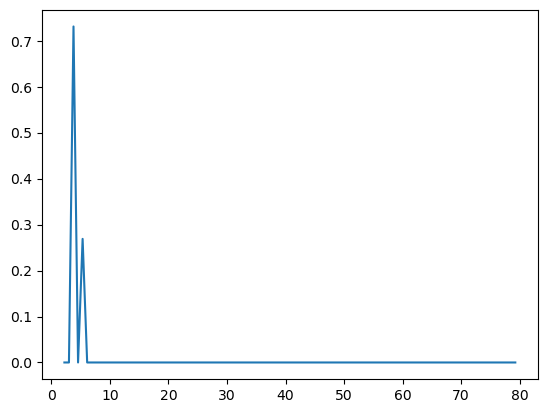

In [96]:
plt.plot(bins[1:], probs)

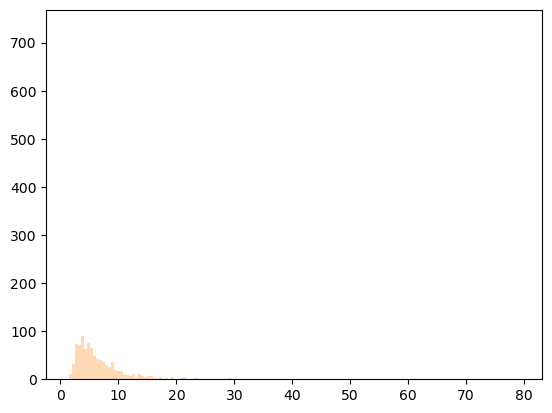

In [87]:
plt.hist(np.random.choice(bins[1:], p=probs, size=1000), alpha=0.3, bins=150)
plt.hist(ngf21['Plx'], bins=150, alpha=0.3);